# Transformers - Trans-U-Net

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

print(os.getcwd())

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code


In [42]:
from constants import TRANSFORMER_DIR
import os

TRANS_U_NET_PATH = os.path.join(TRANSFORMER_DIR, "trans_u_net")
EXPORT_PATH = os.path.join(TRANSFORMER_DIR, "model", "TU_ISIC224")

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
from transformers.trans_u_net.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from transformers.trans_u_net.networks.vit_seg_modeling import VisionTransformer as ViT_seg

VIT_NAME = "R50-ViT-B_16"
PATCH_SIZE = 16
IMAGE_SIZE = 224
NO_CLASSES = 1
NO_SKIP = 3

config_vit = CONFIGS_ViT_seg[VIT_NAME]
config_vit.n_classes = NO_CLASSES
config_vit.n_skip = NO_SKIP
config_vit.patches.size = (PATCH_SIZE, PATCH_SIZE)
config_vit.patches.grid = (int(IMAGE_SIZE / PATCH_SIZE), int(IMAGE_SIZE / PATCH_SIZE))

model = ViT_seg(config_vit, img_size=IMAGE_SIZE, num_classes=NO_CLASSES).to(device)
snapshot = os.path.join(EXPORT_PATH, "TU_pretrain_R50-ViT-B_16_skip3_epo10_bs2_224", "epoch_9.pth")
model.load_state_dict(torch.load(snapshot))

<All keys matched successfully>

In [57]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(224, 224), size=5)

In [62]:
import torch

test_image = test_images[4]
test_image = np.expand_dims(test_image, axis=0)
tensor = torch.from_numpy(test_image).permute(0, 3, 1, 2)
print(tensor.shape)

with torch.no_grad():
    output = model(tensor)
    output = torch.sigmoid(output).round()

print(type(output))

torch.Size([1, 3, 224, 224])
<class 'torch.Tensor'>


(1, 224, 224, 3)


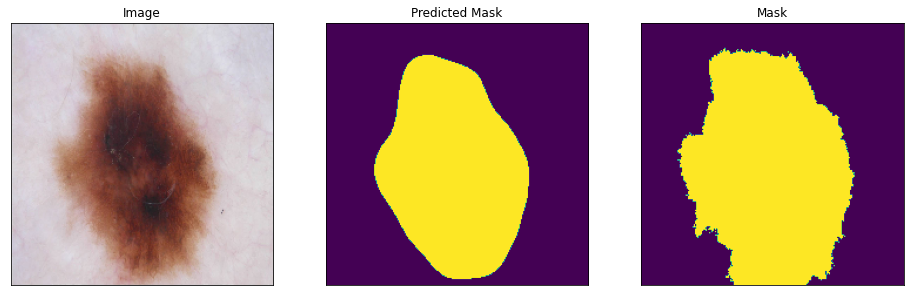

In [63]:
from utils.helper import Visualisation

print(test_image.shape)
output = output.permute(0, 2, 3, 1)

Visualisation().plot_images(
    image=test_image.squeeze(),
    predicted_mask=output.squeeze(axis=0),
    mask=test_masks[4].squeeze()
)